In [1]:
import numpy as np
from numpy.random import permutation
import time
import pandas as pd
import matplotlib.pyplot as plt
fw, fh = plt.rcParams["figure.figsize"]
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import sklearn.model_selection


# Etape 0 : Récupérer les données

In [2]:
path = "eyes_detection_1/"

Nombre d'images

In [3]:
n = 88

Lecture des fichiers textes

In [4]:
array_files = []
for i in range(1,n+1):
  file_path = path + "pixels_faces_"+str(i)+".txt"
  file_tmp = open(file_path, "r")
  array_files.append(file_tmp.read())

Vérification qu'on a lu tous les fichiers

In [5]:
print(np.shape(array_files))

if np.shape(array_files)[0] == n:
  print("Ok")
else:
  print("Le nombre de labels n'est pas le bon.")

(88,)
Ok


### Extraction du label

Le label doit être transformé en tuple de string pour qu'on puisse ensuite créer les sets d'apprentissages et de tests. On doit avoir à la fin y qui est une liste de tuple mais de dimensions 1 pour le training et le test set.

In [6]:
from ast import literal_eval

In [7]:
file_path = path + "points_increment_1.txt"
file_tmp = open(file_path, "r")
tmp = (literal_eval(file_tmp.read()))

In [8]:
array_files_labels = []
for i in range(1,n+1):
  file_path = path + "points_increment_"+str(i)+".txt"
  file_tmp = open(file_path, "r")
  array_files_labels.append(list(literal_eval(file_tmp.read())))

Vérification qu'on a bien tout les labels

In [9]:
print(np.shape(array_files_labels))

if np.shape(array_files_labels)[0] == n:
  print("Ok")
else:
  print("Le nombre de labels n'est pas le bon.")

(88, 2)
Ok


On a le bon nombre d'image et de labels, les données d'entrée sont correctes.

# Etape 2 : Le modèle d'apprentissage

On a un problème de régression car il doit prédire parmi un nombre suffisament grand de classes pour qu'on considère qu'il est infini.

On va utiliser du deep learning pour extraire les caractéristiques et au lieu d'avoir la couche de décision, on remplace cette couche par notre modèle en machine learning de régression.

Import des biblio

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

2024-01-14 19:49:33.890496: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 19:49:33.892051: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 19:49:33.916980: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 19:49:33.917287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 19:49:34.392448: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Création du modèle VGG16 déjà pré entrainé sur un problème de classification (à voir pour trouver un modèle de régression ?)

In [11]:
model = VGG16(weights='imagenet', include_top=False)

Extraction des features (1min)

https://keras.io/api/applications/#extract-features-with-vgg16

In [12]:
array_features = []
n = 88
for i in range(1,n+1):
  img_path = path + "eyes_"+ str(i)+".png"
  #vérifiez pour la target-size à quoi ça correspond
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #Extraction des features
  features = model.predict(x)
  #On crée un tableau pour y stocker chaque feature d'image
  array_features.append(features)

1/1 [==============================] - 0s 187ms/step


https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras

Vérification qu'on a bien toutes les images qui ont été traitées.

In [17]:
print(np.shape(array_features))

if np.shape(array_features)[0] == n:
  print("Ok")
else:
  print("Le nombre d'images n'est pas le bon.")

(88, 1, 7, 7, 512)
Ok


### Redimensionner les données

In [18]:
array_features_final = np.reshape(array_features,(-1,7*7*512))
print(np.shape(array_features_final))

(88, 25088)


Marice sparse ou pas ?

In [19]:
tmp = array_features[0]
print(np.count_nonzero(tmp))
print(np.unique(tmp, return_counts=True))

2092
(array([0.0000000e+00, 9.4871148e-03, 1.6346302e-02, ..., 1.6911436e+02,
       1.7268661e+02, 1.7467064e+02], dtype=float32), array([22996,     1,     1, ...,     1,     1,     1]))


On remarque qu'il y a 10 fois plus de valeurs à 0 que pas à 0.

Une fois les features extraites, on peut récupérer les labels connus pour pouvoir ensuite les attribuer à leurs features.

Il faut créer le test d'entrainement de test

## Centrer les données

 For VGG16, call keras.applications.vgg16.preprocess_input on your inputs before passing them to the model. vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

## Partitionner les données

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train = array_features_final[:60]
X_test = array_features_final[75:]

y_train = array_files_labels[:60]
y_test = array_files_labels[75:]

In [82]:
import pandas as pd
res = pd.DataFrame(index=["MSE"])

## Linear Regression

In [83]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)

LinearRegression()

In [84]:
# Prédictions sur les données de test
predictions = linear_regression.predict(X_test)

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error :", mse)
res.loc[:, "Linear Regression"] = (mse)

Mean Squared Error : 24711.781821508604


# Méthode Deep Learning


In [101]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Reshape
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt


def create_model(image_height,image_width,image_channels):

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, image_channels)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='linear'))  # Output layer for x, y coordinates of the gaze point

    return model

def summary(model):
    model.summary()


def train(model,train_images,train_labels,val_images,val_labels,num_epochs,batch_size):
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=num_epochs, batch_size=batch_size, verbose = 2)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    return model, train_loss,val_loss

def plot_losses(train_loss,validation_loss):

    plt.plot(train_loss, color = "red")
    plt.plot(validation_loss, color = "blue")
    plt.show()

def X(path):
    fichier = open(path, "r")
    image = []
    for line in fichier:
        line = line.split(", ")
        line = list(map(float,line))
        image.append(line)
    return image

def Y(path):
    fichier = open(path, "r")
    for line in fichier:
        output = line.split(", ")
    return (int(output[0]),int(output[1]))

def dataset(images,outputs,train_size,val_size,test_size):
    train_images = images[:train_size]
    train_labels = outputs[:train_size]

    val_images = images[train_size:train_size+val_size]
    val_labels = outputs[train_size:train_size+val_size]

    test_images = images[train_size+val_size:train_size+val_size+test_size]
    test_labels = outputs[train_size+val_size:train_size+val_size+test_size]

    return np.array(train_images),np.array(train_labels),np.array(val_images),np.array(val_labels),np.array(test_images),np.array(test_labels)

def test(image,output,model):
    pred = model.predict(image)
    #dist = ((output[0]-)**2 + (output[1]-y)**2)**(1/2)
    return pred

In [102]:
images = list()
outputs = list()
train_size = 60
val_size = 15
test_size = 13
for i in range(1,train_size+val_size+test_size+1):
    image = X("eyes_detection_1/pixels_faces_"+str(i)+".txt")
    output = Y("eyes_detection_1/points_increment_"+str(i)+".txt")
    images.append(image)
    outputs.append(output)

train_images,train_labels,val_images,val_labels,test_images,test_labels = dataset(images,outputs,train_size,val_size,test_size)


In [103]:
train_images = train_images.astype('float32')
train_labels = train_labels.astype('float32')

val_images = val_images.astype("float32")
val_labels = val_labels.astype("float32")

test_images = test_images.astype('float32')
test_labels = test_labels.astype('float32')




In [104]:
batch_size = 1
epochs = 64

image_height = 100
image_width = 200
image_channels = 1

model = create_model(image_height=image_height,image_width=image_width,image_channels = image_channels)
model,train_loss,val_loss = train(model,train_images,train_labels,val_images,val_labels,epochs,batch_size)

Epoch 1/64
60/60 - 2s - loss: 204550.9688 - val_loss: 128697.6797 - 2s/epoch - 26ms/step
Epoch 2/64
60/60 - 1s - loss: 66833.0156 - val_loss: 74108.5703 - 1s/epoch - 22ms/step
Epoch 3/64
60/60 - 2s - loss: 29194.8379 - val_loss: 25292.0371 - 2s/epoch - 25ms/step
Epoch 4/64
60/60 - 1s - loss: 16087.2568 - val_loss: 15756.6914 - 1s/epoch - 24ms/step
Epoch 5/64
60/60 - 1s - loss: 15550.5469 - val_loss: 29280.2285 - 1s/epoch - 21ms/step
Epoch 6/64
60/60 - 1s - loss: 8421.9551 - val_loss: 13736.0166 - 1s/epoch - 21ms/step
Epoch 7/64
60/60 - 1s - loss: 5977.1626 - val_loss: 19241.8496 - 1s/epoch - 20ms/step
Epoch 8/64
60/60 - 1s - loss: 4328.0176 - val_loss: 14709.2871 - 1s/epoch - 21ms/step
Epoch 9/64
60/60 - 1s - loss: 3354.8010 - val_loss: 11449.2949 - 1s/epoch - 21ms/step
Epoch 10/64
60/60 - 1s - loss: 2136.6082 - val_loss: 15086.8281 - 1s/epoch - 21ms/step
Epoch 11/64
60/60 - 1s - loss: 1066.6431 - val_loss: 15717.4258 - 1s/epoch - 21ms/step
Epoch 12/64
60/60 - 1s - loss: 1220.7371 - va

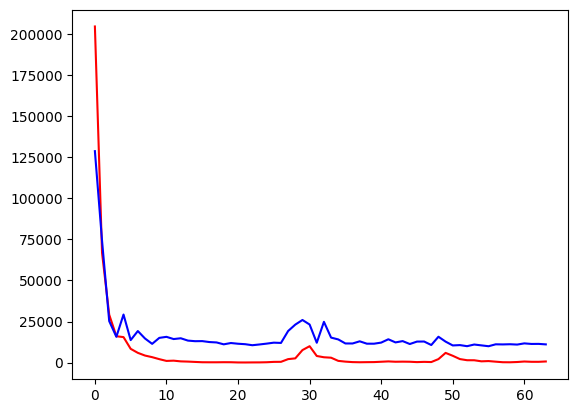

In [105]:
plot_losses(train_loss,val_loss)

In [106]:
pred = test(test_images,test_labels,model)
pred

1/1 [==============================] - 0s 70ms/step


array([[1214.2661  ,  872.11847 ],
       [ 248.99883 ,   67.25469 ],
       [ 486.812   ,  371.6669  ],
       [ 728.3334  ,  -82.86021 ],
       [ 644.04333 ,  -38.948242],
       [ 241.77031 ,  461.5605  ],
       [1362.081   ,   81.94906 ],
       [ 459.78363 ,  700.17377 ],
       [ 356.46863 ,  343.9984  ],
       [1059.4181  ,   71.40541 ],
       [ 726.35925 ,  678.2409  ],
       [ 709.26794 ,  320.17487 ],
       [ 973.59717 ,  681.66315 ]], dtype=float32)

In [107]:
# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error Linear Regression:", mse)
mse_2 = mean_squared_error(y_test, pred)
print("Mean Squared Error Deep Learning Model:",mse_2)


Mean Squared Error Linear Regression: 24711.781821508604
Mean Squared Error Deep Learning Model: 7177.598796002815
